In [1]:
import numpy as np
from model import *
import tensorflow as tf
import setGPU
#strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

imgs = np.expand_dims(np.load('../dataset/cv/train/x/generated_text.npz')['arr_0'], axis=-1)
labels = np.load('../dataset/cv/train/y/generated_labels.npy')

setGPU: Setting GPU to: 0


In [2]:
#imgs = imgs/255

In [3]:
characters = set(char for label in labels for char in label)

In [4]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [5]:
imgs = np.transpose(imgs, (0, 2, 1, 3))
'''
max_len = max([len(label) for label in labels])
encoded_labels = []
for label in labels:
    if label:
        tmp = np.array([char_to_num(char) for char in label])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
    else:
        tmp = np.array([char_to_num('#')])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
'''

encoded_labels = np.load('../dataset/cv/train/y/encoded_generated_labels.npy')

In [6]:
#Si inserisce alla fine di ogni array label la lunghezza reale della parola
t_dist_dim = int(128)          # Questo valore indica quanti step temporali ci sono: nelle ultime feature map ci sono 128/4
                                 # step temporali perché 128 è la larghezza massima tra le immagini in ingresso e 4 è il fattore
                                 # di riduzione dovuto ai MaxPooling (ci sono 2 livelli di MaxPooling che dimezzano le dimensioni)
enc2 = []
for i in range(encoded_labels.shape[0]):
    if len(labels[i]) == 0:
        enc2.append(np.append(encoded_labels[i], [1, t_dist_dim]))
    else:
        enc2.append(np.append(encoded_labels[i], [len(labels[i]), t_dist_dim]))
enc2 = np.array(enc2)

In [7]:
#with strategy.scope():
net = build_and_compile_model_v9_7(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")

In [8]:
net.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)     

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Early_Stopping_Patience = 10 
Min_Delta = 0.0001
# Model Check Point
Check_Point = ModelCheckpoint( 'weights/CRNN_v9_7.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0002)

In [11]:
batch_size = 64
x_train = imgs
y_train = enc2

In [12]:
history = net.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[Check_Point, reduce_lr], batch_size=batch_size, shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 35.9965
Epoch 00001: val_loss improved from inf to 28.05896, saving model to weights/CRNN_v9_7.h5
125/125 [==============================] - 61s 486ms/step - loss: 35.9965 - val_loss: 28.0590
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 26.4929
Epoch 00002: val_loss did not improve from 28.05896
125/125 [==============================] - 60s 478ms/step - loss: 26.4929 - val_loss: 100.3777
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 26.3623
Epoch 00003: val_loss improved from 28.05896 to 26.45493, saving model to weights/CRNN_v9_7.h5
125/125 [==============================] - 60s 481ms/step - loss: 26.3623 - val_loss: 26.4549
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 26.2671
Epoch 00004: val_loss did not improve from 26.45493
125/125 [==============================] - 60s 478ms/step - loss: 26.2671 - val_loss: 26.5549
Epoch 5/100
125/12

125/125 [==============================] - 60s 480ms/step - loss: 0.8300 - val_loss: 0.9368
Epoch 33/100
125/125 [==============================] - ETA: 0s - loss: 0.7304
Epoch 00033: val_loss did not improve from 0.93682
125/125 [==============================] - 60s 477ms/step - loss: 0.7304 - val_loss: 3.5426
Epoch 34/100
125/125 [==============================] - ETA: 0s - loss: 0.6957
Epoch 00034: val_loss did not improve from 0.93682
125/125 [==============================] - 60s 477ms/step - loss: 0.6957 - val_loss: 1.2242
Epoch 35/100
125/125 [==============================] - ETA: 0s - loss: 0.6580
Epoch 00035: val_loss improved from 0.93682 to 0.88149, saving model to weights/CRNN_v9_7.h5
125/125 [==============================] - 60s 478ms/step - loss: 0.6580 - val_loss: 0.8815
Epoch 36/100
125/125 [==============================] - ETA: 0s - loss: 0.6499
Epoch 00036: val_loss did not improve from 0.88149
125/125 [==============================] - 60s 477ms/step - loss: 0.64

Epoch 68/100
125/125 [==============================] - ETA: 0s - loss: 0.1417
Epoch 00068: val_loss did not improve from 0.56931
125/125 [==============================] - 59s 474ms/step - loss: 0.1417 - val_loss: 0.6201
Epoch 69/100
125/125 [==============================] - ETA: 0s - loss: 0.1394
Epoch 00069: val_loss did not improve from 0.56931
125/125 [==============================] - 59s 475ms/step - loss: 0.1394 - val_loss: 0.6251
Epoch 70/100
125/125 [==============================] - ETA: 0s - loss: 0.1331
Epoch 00070: val_loss did not improve from 0.56931
125/125 [==============================] - 59s 476ms/step - loss: 0.1331 - val_loss: 0.6482
Epoch 71/100
125/125 [==============================] - ETA: 0s - loss: 0.1314
Epoch 00071: val_loss did not improve from 0.56931
125/125 [==============================] - 59s 475ms/step - loss: 0.1314 - val_loss: 0.6595
Epoch 72/100
125/125 [==============================] - ETA: 0s - loss: 0.1222
Epoch 00072: val_loss did not imp

In [43]:
net.save_weights('weights/CRNN_v9_7_last.h5')

In [45]:
net.load_weights('weights/CRNN_v9_7.h5')

In [44]:
np.save('history/my_history_v9_7.npy', history.history)

In [23]:
import numpy as np
his = np.load('my_history_v5.npy', allow_pickle=True)

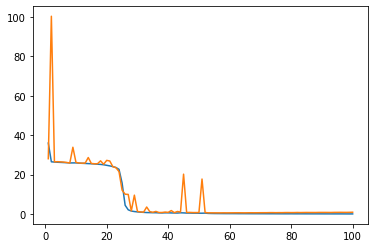

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), history.history['loss'])
plt.plot(range(1, 101), history.history['val_loss'])

In [14]:
import imageio

im = imageio.imread('../dataset/cv/train/mario.png')

In [16]:
import cv2
from skimage import color

im = cv2.resize(im, (128, 128))
im = color.rgb2gray(im)

NameError: name 'im' is not defined

In [16]:
im = np.expand_dims(im, axis=-1)

In [15]:
def decode_ctc(args):
    """returns a list of decoded ctc losses"""

    y_pred, input_length = args

    ctc_decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length, greedy=True)

    return ctc_decoded

In [17]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(imgs[0], axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [18]:
pred_labels

array([[55, 13, 22, 21, 14, 26, 16,  4,  1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [19]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b't', b'D', b'M', b'L', b'E', b'Q', b'G', b'4', b'1', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UN

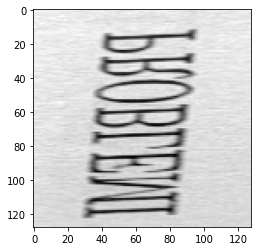

In [67]:
import matplotlib.pyplot as plt
plt.imshow(im, cmap='gray')
plt.show()

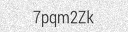

In [63]:
from trdg.generators import GeneratorFromRandom  
base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length=1, width=128, size=32)
img, lbl = next(base_generator)
display(img)

In [64]:
im = cv2.resize(np.array(img), (128, 128))
im = color.rgb2gray(im)
im = np.expand_dims(im, axis=-1)
im = np.transpose(im, (1, 0, 2))

In [48]:
im.shape

(128, 128, 1)

In [60]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

In [61]:
pred_labels

array([[47, 25, 27, 26, 11, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [62]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'l', b'P', b'R', b'Q', b'B', b'h', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[

In [20]:
labels[0]

'tDMLEQG41'

In [66]:
import imageio
mario = imageio.imread('../dataset/cv/train/mario.png')
im = cv2.resize(np.array(mario), (128, 128))
im = color.rgb2gray(im)
im = np.expand_dims(im, axis=-1)
im = np.transpose(im, (1, 0, 2))

<ipython-input-66-dd01b744b0dc>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im = color.rgb2gray(im)
